In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

In [3]:
DATA_PATH = '../data/processed/data_processed.csv'
data = pd.read_csv(DATA_PATH)

In [4]:
data.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [5]:
data['datetime'] = pd.to_datetime(data.datetime)
data.dropna(inplace=True, how='any')

In [6]:
data_per_id = data.loc[data.machineID==1]

#### Maybe do some datetime calculations to create more features

In [7]:
data_cols = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','model_model1', 'model_model2', 'model_model3', 'model_model4']

target_cols = ['comp1_life', 'comp2_life', 'comp3_life', 'comp4_life']

In [8]:
N_features = len(data_cols)

In [9]:
X_df = data_per_id[data_cols]
X = X_df.values

y_df = [data_per_id[target_col] for target_col in target_cols]
y = np.array([y_df_i.values for y_df_i in y_df]).T

In [10]:
data['comp2_life'].isnull().sum()

0

In [11]:
train_size_pc = 0.85
train_idx = np.floor(train_size_pc*X.shape[0]).astype(int)

X_train = X[:train_idx]
X_test = X[train_idx:]

y_train = y[:train_idx]
y_test = y[train_idx:]

In [25]:
y_test[:,0].shape

(8,)

In [13]:
N_train = y_train.shape[0]
N_test = y_test.shape[0]

Try using an LDS to model the temporal dynamics of the measurements of each machine, per `machine_ID`.
The generative process is the following:  
$$
process
$$


In [14]:
# def f2(carry, inputs):
        
#     u_input, noise_t = inputs
    
#     z_prev, betas, tau, R = carry
            
#     # Create the B state matrix
#     n_states_ = len(z_prev.flatten())
#     B = jnp.eye(n_states_)
    
#     # B[0] = betas
#     B = B.at[0].set(betas)
        
#     z_t = jnp.dot(B, z_prev) + tau*noise_t  + jnp.dot(R, u_input) 

#     for i in range(len(z_prev.flatten())):
#         # z_prev[i] = z_t[i]
#         z_prev = z_prev.at[i].set(z_t[i])
      

#     betas = B[0]
    
#     print(f'betas: {betas.shape}')
#     print(f'z_prev: {z_prev.shape}')
#     print(f'tau: {tau.shape}')
#     print(f"R: {R.shape}")
#     print(f'z_t: {z_t.shape}')    
#     return (betas, z_prev, tau, R), z_t

In [15]:
# n_states = 24

In [16]:
# def model(T, T_forecast, X, obs=None):
#     """ Define priors over B, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
#     # Your code here
#     """
    
#     global n_states
    
    
# #     beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=5.))
# #     beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=5.))

#     tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    
# #     noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))

#     sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
    
# #     z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0., scale=3.))
# #     z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0., scale=3.))
    
#     noises = numpyro.sample("noises", fn=dist.Normal(jnp.zeros(T+T_forecast-n_states),
#                                                     jnp.ones(T+T_forecast-n_states)))
    
#     n, p = X.shape
            
#     sigma_eta = 1.
    
#     eta = numpyro.sample(name="eta", fn=dist.Normal(loc=jnp.zeros(p), scale=jnp.ones(p)*sigma_eta))
        
#     scale_z = 3.
#     z_prev = np.array([numpyro.sample(name=f"z_prev_{i}", fn=dist.Normal(loc=0., scale=scale_z)) for i in range(1,n_states+1)]) 
        
#     scale_b = 5.
#     betas = np.array([numpyro.sample(name=f"beta_{i}", fn=dist.Normal(loc=0., scale=scale_b)) for i in range(1,n_states+1)]) 
        
#     """ Propagate the dynamics forward using jax.lax.scan
#     carry = (beta1, beta2, z_prev1, z_prev2, tau)
#     z_collection = [z_prev1, z_prev2]
#     # Your code here
#     """
    
#     carry = (betas, z_prev, tau, eta)
#     z_collection = jnp.array([z_prev[i] for i in range(len(z_prev.flatten()))]).reshape(1,-1)
        
#     carry, zs_exp = lax.scan(f2, carry, xs=[X,noises], length= T+T_forecast-n_states)
    
#     z_collection = jnp.concatenate((z_collection, zs_exp), axis=0)
    
    
#     """ Sample the observed_y (y_obs) and predicted_y (y_pred) - note that you don't need a pyro.plate!
#     # Your code here
#     """
#     numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs[:T])    
#     numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
#     return z_collection

In [17]:
def f(carry, inputs):
    
    noise_t, inpts = inputs
    
    beta, z_prev, tau, R = carry
    z_t = beta*z_prev + noise_t + jnp.dot(R, inpts)
    z_prev = z_t
    return (beta, z_prev, tau, R), z_t

In [18]:
def model(T, T_forecast, n_series=4, obs=None, inputs=None, n_previous=1):
    """
    Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    """
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros(n_series), scale=jnp.ones(n_series)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(n_series)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(n_series), scale=jnp.ones(n_series)))
    
    n,p = inputs.shape
    R = numpyro.sample(name="R", fn=dist.Normal(loc=jnp.zeros((n_series, p)), scale=jnp.ones((n_series, p))))
    
    
    """
    Define LKJ prior
    """
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(n_series, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(n_series), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-n_previous,))
    
    """
    Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta, z_prev, tau, R)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, [noises, inputs], T+T_forecast-n_previous)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    

    
    for i in range(n_series):
        numpyro.sample(name=f"y_obs{i+1}", fn=dist.Normal(loc=z_collection[:T, i], scale=sigma), obs=obs[:,i])
        numpyro.sample(name=f"y_pred{i+1}", fn=dist.Normal(loc=z_collection[T:, i], scale=sigma), obs=None)
        
    return z_collection

In [20]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

n_series = 4
n_previous = 1
T = N_train
T_forecast = N_test


X_t = np.concatenate([X_train[n_previous:,:], X_test], axis=0)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=4)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, n_series=n_series, inputs=X_t, obs=y_train, n_previous=n_previous)

/tmp/ipykernel_33474/2542263695.py:13: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=4)
sample: 100%|█| 4000/4000 [00:28<00:00, 139.37it/s, 255 steps of size 5.00e-03. ac
sample: 100%|█| 4000/4000 [00:12<00:00, 324.84it/s, 255 steps of size 5.00e-03. ac
sample: 100%|█| 4000/4000 [00:03<00:00, 1021.29it/s, 1 steps of size 5.00e-03. acc
sample: 100%|█| 4000/4000 [00:04<00:00, 856.16it/s, 1 steps of size 5.00e-03. acc.


In [21]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[0,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[0,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[1,0]     -0.18      0.25     -0.19     -0.46      0.23      4.41      1.74
L_Omega[1,1]      0.95      0.04      0.97      0.89      0.99      2.46      2.34
L_Omega[1,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[1,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[2,0]     -0.29      0.34     -0.20     -0.84      0.09      2.30      3.11
L_Omega[2,1]      0.17      0.20      0.18     -0.23      0.36      4.87      1.47
L_Omega[2,2]      0.83      0.18      0.91      0.52      0.98      2.05      6.71
L_O

In [22]:
# Get parameter samples
samples_ = mcmc.get_samples()
# nodes_ = ["beta_1", "beta_2","eta", "tau", "sigma"]
# for node in nodes_:
#     plt.figure(figsize=(10,3))
#     sns.displot(samples_[node], label=node)
#     plt.legend()
#     plt.show()

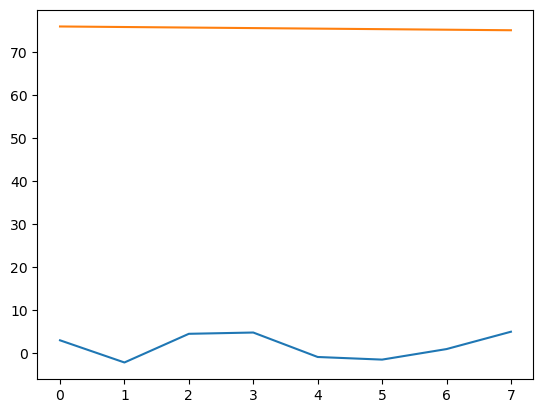

In [26]:
plt.plot(samples_['y_pred1'].mean(axis=0))
plt.plot(y_test[:,0])
plt.show()

In [ ]:
y_test[:,0]

In [ ]:
# Trace plots
f, ax = plt.subplots(5, 1)
ax[0].plot(samples_['beta_1'])
ax[1].plot(samples_['beta_2'])
ax[2].plot(samples_['eta'])
ax[3].plot(samples_['tau'])
ax[4].plot(samples_['sigma'])

In [ ]:
def compute_predictions(samples):
    """
    Computes the mean and standard deviation of a given sample and re-normalizes the
    values given a certain mean and standard deviation. Returns a re-normalized vector.
    """

    y_hat_mean = samples.mean(axis=0).reshape(-1,)
    y_hat_std = samples.std(axis=0).reshape(-1,)
    # y_hat_025 = (y_hat_mean - 1.96*y_hat_std) * y_std + y_mean
    # y_hat_975 = (y_hat_mean + 1.96*y_hat_std) * y_std + y_mean
    y_hat_renormalized = y_hat_mean
    return y_hat_renormalized #, y_hat_025, y_hat_975

In [ ]:
def compute_error(trues, predicted):
    """
    Computes the error given a vector of actual measurements against predicted. Returns
    a list with the correlation, MAE, RAE, RMSE, and R2 between these two vectors.
    """

    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return [corr, mae, rae, rmse, r2]

In [ ]:
y_hat = compute_predictions(samples_["y_pred1"])

In [ ]:
y_hat.shape, y_test.shape

In [ ]:
compute_error(y_test[:,0].flatten(), y_hat)

In [ ]:
y_hat

In [ ]:
y_test.flatten()

In [ ]:
plt.plot(y_hat, label='$\hat{y}$')
plt.plot(y_test, label='y')
plt.legend()
plt.show()